In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-03-01 02:53:57.406862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load your data
df = pd.read_csv('sorted_stock_data_cleaned_nica.csv')  # Replace with your file
print(df.head())


    Open   High    Low  Close  per_change     Qty    EPS         PE
0  678.0  666.0  658.0  660.0         0.0  3547.0  17.94  36.789298
1  660.0  660.0  647.0  651.0         0.0  5758.0  17.94  36.287625
2  651.0  655.0  644.0  646.0         0.0  6085.0  17.94  36.008919
3  646.0  651.0  642.0  648.0         0.0  6977.0  17.94  36.120401
4  648.0  651.0  643.0  648.0         0.0  3303.0  17.94  36.120401


In [3]:
# Ensure all 6 columns are present (adjust if needed)
feature_columns = ['Open', 'High', 'Low', 'Close', 'per_change', 'Qty']  # Your 8 features
data = df[feature_columns].values

In [4]:
# Scale all 8 features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
# Sequence creation function
def create_sequences_multivariate(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])   # n_steps timesteps, each with 8 features
        y.append(data[i+n_steps])      # Predict all 8 features at next step
    return np.array(X), np.array(y)

In [6]:
# Parameters
n_steps = 60  # Past 60 days used for prediction


In [7]:
# Create sequences
X, y = create_sequences_multivariate(scaled_data, n_steps)

In [8]:
# Train-test split
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
# Define Bidirectional LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps, 6)),
    Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(6)
    
])
# model.add(LSTM(128, return_sequences=True), input_shape=(n_steps, 8))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(64, return_sequences=False)))
# model.add(Dropout(0.3))
# model.add(Dense(8))  # Predict all 8 features at once

In [10]:
model.compile(optimizer='adam', loss='mse')

In [11]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]


In [12]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=callbacks)

Epoch 1/100
21/21 [==============================] - 8s 169ms/step - loss: 0.0412 - val_loss: 0.0089 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 3s 121ms/step - loss: 0.0161 - val_loss: 0.0091 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 3s 136ms/step - loss: 0.0140 - val_loss: 0.0065 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 3s 143ms/step - loss: 0.0119 - val_loss: 0.0064 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 3s 122ms/step - loss: 0.0116 - val_loss: 0.0063 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 3s 122ms/step - loss: 0.0109 - val_loss: 0.0086 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 3s 121ms/step - loss: 0.0112 - val_loss: 0.0069 - lr: 0.0010
Epoch 8/100
21/21 [==============================] - 3s 127ms/step - loss: 0.0095 - val_loss: 0.0058 - lr: 0.0010
Epoch 9/100
21/21 [==============================] - 3s 126ms/step - loss: 0.0090 - val_

In [13]:
model.save('final_model_60_noEps.keras')

In [ ]:
model.summary()

In [14]:
# from keras.models import Sequential, load_model
# from keras.layers import LSTM, Dense, Dropout
# model = load_model('final_model_60.keras')

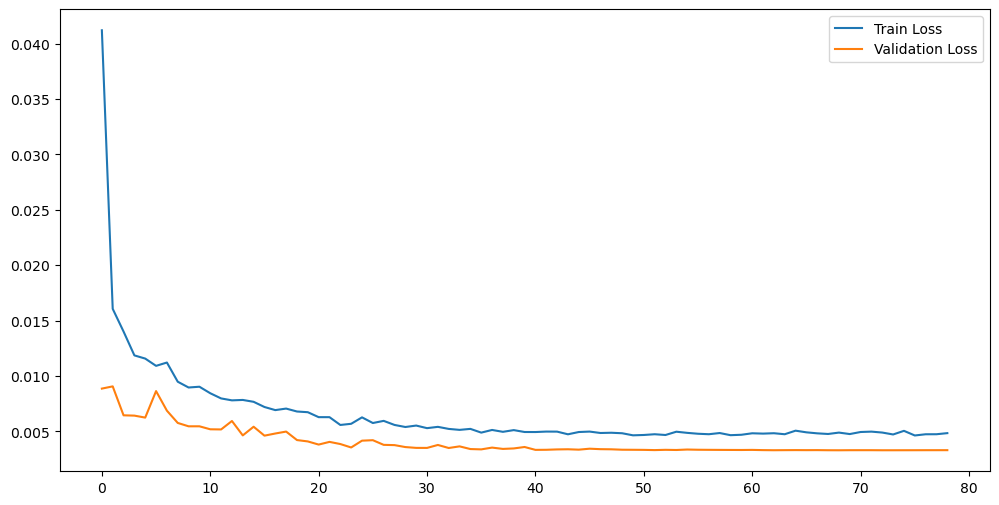

In [15]:

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [16]:
## for the X_train
train_result=model.predict(X_train)
train_result_inverse=scaler.inverse_transform(train_result)
train_result_close=train_result_inverse[:, 3]


53/53 [==============================] - 3s 29ms/step


In [17]:
## for the X_test
test_result=model.predict(X_test)
test_result_inverse=scaler.inverse_transform(test_result)
test_result_close=test_result_inverse[:, 3]


6/6 [==============================] - 0s 30ms/step


In [18]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
print("MAE of close:", mean_absolute_error(y_test[:,3], test_result[:,3]))
print("R² Score of close:", r2_score(y_test[:,3], test_result[:,3]))
print("MSE of close:", mean_squared_error(y_test[:,3], test_result[:,3]))
print("MAPE of close:", mean_absolute_percentage_error(y_test[:,3], test_result[:,3]))


MAE of close: 0.03486288126687023
R² Score of close: 0.5275090532274553
MSE of close: 0.0019894964669472637
MAPE of close: 0.21351409561431864


In [19]:
print("MAE of Test:", mean_absolute_error(y_test, test_result))
print("R² Score TESt:", r2_score(y_test, test_result))
print("MSE TESt:", mean_squared_error(y_test, test_result))
print("MAPE of Test:", mean_absolute_percentage_error(y_test, test_result))

MAE of Test: 0.05289041241622531
R² Score TESt: 0.38870887565275014
MSE TESt: 0.007203359322439999
MAPE of Test: 0.27019782009569676


In [20]:
print("MAE of Train:", mean_absolute_error(y_train, train_result))
print("R² Score Train:", r2_score(y_train, train_result))
print("MSE Train:", mean_squared_error(y_train, train_result))
print("MAPE of Train:", mean_absolute_percentage_error(y_train, train_result))

MAE of Train: 0.03170743302866274
R² Score Train: 0.7394897957776153
MSE Train: 0.0029403534279007246
MAPE of Train: 338127282982.3923


In [21]:
X_test.shape, X_train.shape, y_test.shape, y_train.shape

((186, 60, 6), (1674, 60, 6), (186, 6), (1674, 6))

In [22]:
# Function to predict future days recursively (all 8 features)
def predict_future_multivariate(model, data, scaler, n_steps, future_days):
    predicted = []
    current_sequence = data[-n_steps:]  # Last window of data

    for _ in range(future_days):
        prediction = model.predict(current_sequence.reshape(1, n_steps, 6), verbose=0)
        predicted.append(prediction[0])

        # Append predicted row to current sequence for next prediction
        current_sequence = np.vstack([current_sequence[1:], prediction])

    # Inverse transform all predicted data (8 features)
    predicted_array = np.array(predicted)
    predicted_prices = scaler.inverse_transform(predicted_array)
    return predicted_prices

In [23]:
# Predict next 30 days
future_days = 150
future_prices = predict_future_multivariate(model, scaled_data, scaler, n_steps, future_days)

In [24]:
# Plot actual vs future Close prices
actual_close_prices = df['Close'].values

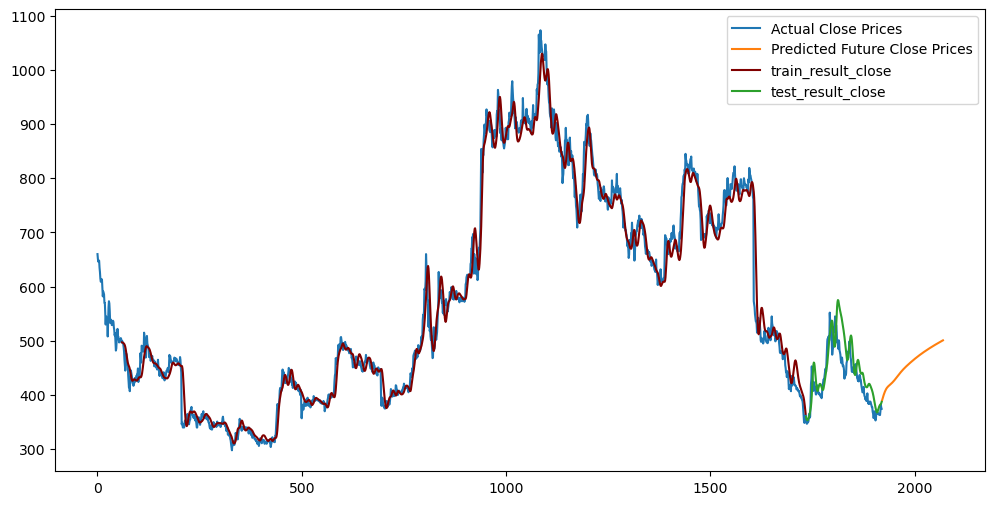

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(actual_close_prices, label='Actual Close Prices')
plt.plot(range(len(actual_close_prices), len(actual_close_prices) + future_days), future_prices[:, 3], label='Predicted Future Close Prices')
plt.plot(range(n_steps, len(train_result_close)+n_steps),train_result_close,label="train_result_close", color="maroon" )
plt.plot(range(len(train_result_close)+n_steps, len(train_result_close)+len(test_result_close)+n_steps),test_result_close,label="test_result_close" )
plt.legend()
plt.savefig("close_pred_future.png")
plt.show()

In [26]:
# Print predicted future prices (all features for each day)
future_df = pd.DataFrame(future_prices, columns=feature_columns)
print(future_df)

           Open        High         Low       Close  per_change           Qty
0    388.829773  395.387329  385.971344  389.963593    0.300514  75493.656250
1    391.384186  397.923615  388.426331  392.627197    0.301313  75806.148438
2    393.910278  400.428192  390.822021  395.222778    0.297805  76077.390625
3    396.361420  402.863403  393.138275  397.718201    0.290402  76293.882812
4    398.710022  405.205017  395.364410  400.094818    0.279738  76454.101562
..          ...         ...         ...         ...         ...           ...
145  499.946564  507.042572  492.877197  499.193085    0.063217  67138.218750
146  500.374329  507.472137  493.288940  499.613312    0.063056  67167.421875
147  500.800537  507.900055  493.699158  500.031891    0.062898  67197.203125
148  501.225098  508.326355  494.107849  500.448975    0.062742  67227.531250
149  501.648071  508.751160  494.515045  500.864502    0.062591  67258.406250

[150 rows x 6 columns]


In [27]:
# Save to CSV if needed
future_df.to_csv('predicted_future_prices_withoutEPS.csv', index=False)